In [7]:
import numpy as np
model_predict = np.load('dataset/unicmp_gatv2_edge_all.npy')
np.set_printoptions(suppress=True)
model_predict.shape

(3655452, 23)

In [16]:
max_probs = np.max(model_predict, axis=-1)
model_predict_label = np.argmax(model_predict, axis=-1)
max_probs.shape, model_predict_label.shape

((3655452,), (3655452,))

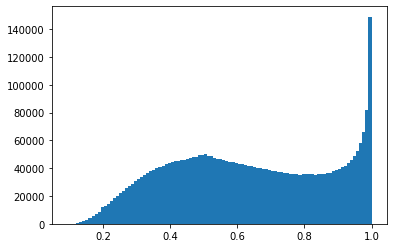

In [9]:
import matplotlib.pyplot as plt
plt.hist(max_probs, bins=100)
plt.show()

In [36]:
import pickle
import os
base_path='./dataset'
with open(os.path.join(base_path, 'k_fold_labels.pkl'), 'rb') as f:
    label_data = pickle.load(f)
    labels = label_data['label']
    test_label_idx = label_data['test_label_idx']
labels.shape

(3655452,)

In [10]:
base_path='./dataset'
neighbors_class_count = np.load(os.path.join(base_path, 'neighbors_class_count.npy'))
neighbors_class_count.shape

(3655452, 2, 24)

In [12]:
edge_num = np.sum(neighbors_class_count.reshape((-1,48)), axis=-1) # 每个点的边的个数
class_edge_num = np.sum(neighbors_class_count[:,:,:23].reshape((-1,46)), axis=-1) # 每个点有标签的边的个数
edge_num.shape, class_edge_num.shape

((3655452,), (3655452,))

In [13]:
# 自己没有标签 但是周围有标签的
# 260w自己没标签其中174W周围有标签
c1 = labels==-1
c2 = class_edge_num!=0
c3 = c1*c2
np.sum(c1), np.sum(c3)

(2611035, 1741613)

In [18]:
label_count = np.sum(neighbors_class_count[:,:,:23],-2) # 去除无标签统计
max_num_label_all_rate = np.max(label_count, axis=-1)/(edge_num+0.1)
max_num_label_all_rate.shape

(3655452,)

In [19]:
neighbors_max_label = np.argmax(label_count, axis=-1)
neighbors_max_label.shape

(3655452,)

In [26]:
c4 = neighbors_max_label == model_predict_label
c5 = max_num_label_all_rate>=0.5

In [17]:
# 无标签且预测大于0.8的 有60w
# 无标签且预测大于0.7的 有90w
np.sum((max_probs>0.8)*c1), np.sum((max_probs>0.7)*c1)

(639996, 926208)

In [44]:
# 无标签且预测大于0.8的 且周围最大标签相一致至 有60w
# 无标签且预测大于0.7的 且周围最大标签相一致至 有90w
np.sum((max_probs>0.8)*c1*c4*c5), np.sum((max_probs>0.7)*c1*c4*c5), np.sum((max_probs>0.6)*c1*c4*c5), np.sum((max_probs>0.5)*c1*c4*c5)

(73873, 88558, 101776, 112654)

In [33]:
new_labels = np.array(labels)
new_labels.shape

(3655452,)

In [45]:
# 打10w的标签
label_condition = (max_probs>0.5)*c1*c4*c5
new_labels[label_condition] = neighbors_max_label[label_condition]
np.sum(labels==-1), np.sum(new_labels==-1)

(2611035, 2498381)

In [46]:
np.save('dataset/new_labels',new_labels)

In [47]:
# 预测和周围完全不同的个数
c6 = neighbors_max_label != model_predict_label
np.sum((max_probs>0.6)*c1*c6*c5)

6352

In [48]:
test_c = np.zeros(labels.shape)
test_c[test_label_idx] = 1
test_c = np.array(test_c, dtype=np.bool)

In [49]:
# 测试集中打标签的数量 60w/300w = 0.2 0.2*10w=2w
np.sum(test_c*label_condition)

39452